# WARNING: This notebook is still under contruction

In [1]:
import os, pickle, time
import numpy as np
import healpy as hp
from beamconv import ScanStrategy, tools
import matplotlib.pyplot as plt
import qpoint as qp
import seaborn as sns
sns.set()
%matplotlib inline

In [2]:
def get_cls(fname='../ancillary/wmap7_r0p03_lensed_uK_ext.txt'):
    cls = np.loadtxt(fname, unpack=True) # Cl in uK^2
    return cls[0], cls[1:]

In [3]:
nsamp      = 1000
sample_rate = 10.
lmax       = 700
mmax       = 5
fwhm       = 30.
ra0        = -10 
dec0       = -57.5
az_throw   = 50
nside_spin = 512

In [34]:
# Load up alm                                                                            
ell, cls = get_cls()
np.random.seed(39)
alm = hp.synalm(cls, lmax=lmax, new=True, verbose=True) # uK  

# Turning off polarization input
#alm[1] = 0
#alm[2] = 0

In [35]:
# create Beam properties and pickle (this is just to test load_focal_plane)              
opj = os.path.join
blm_dir = os.path.abspath('../tests/test_data/example_blms')
po_file = opj(blm_dir, 'blm_hp_X1T1R1C8A_800_800.npy')
eg_file = opj(blm_dir, 'blm_hp_eg_X1T1R1C8A_800_800.npy')

beam_file1 = 'beam_opts1.pkl'
#beam_file2 = 'beam_opts2.pkl'
beam_opts1 = dict(az=0,
                 el=0,
                 polang=0.,
                 btype='Gaussian',
                 name='X1T1R1C8',
                 fwhm=32.2,
                 lmax=800,
                 mmax=800,
                 amplitude=1.,
                 po_file=po_file,
                 eg_file=eg_file,
                 deconv_q=True,  # blm are SH coeff from hp.alm2map                      
                 normalize=True)

#beam_opts2 = dict(az=0,
#                 el=0,
#                 polang=0.,
#                btype='Gaussian',
#                 name='X1T1R1C7',
#                 fwhm=28.2,
#                 lmax=800,
#                 mmax=800,
#                 amplitude=1.,
#                 po_file=po_file,
#                 eg_file=eg_file,
#                 deconv_q=True,  # blm are SH coeff from hp.alm2map                      
#                 normalize=True)

with open(beam_file1, 'wb') as handle:
    pickle.dump(beam_opts1, handle, protocol=pickle.HIGHEST_PROTOCOL)
#with open(beam_file2, 'wb') as handle:
#    pickle.dump(beam_opts2, handle, protocol=pickle.HIGHEST_PROTOCOL)   

In [36]:
# init scan strategy and instrument                                                      
ss = ScanStrategy(nsamp/sample_rate, # mission duration in sec.                                  
                  sample_rate=sample_rate, # 10 Hz sample rate                                    
                  location='spole') # South pole instrument                              

#ss.load_focal_plane('.', no_pairs=False)
ss.load_focal_plane('.')

In [37]:
# Generate timestreams with Gaussian beams
ss.scan_instrument_mpi(alm, verbose=1, ra0=ra0, dec0=dec0, az_throw=az_throw,
    nside_spin=nside_spin, max_spin=mmax, binning=False, ctalk=0.01, save_tod=True)

tod_ctalk = ss.tod.copy()

#ss.scan_instrument_mpi(alm, verbose=1, ra0=ra0, dec0=dec0, az_throw=az_throw,
#    nside_spin=nside_spin, max_spin=mmax, binning=False, ctalk=0.)
#tod = ss.tod.copy()

print(np.shape(tod_ctalk))

Scanning with 2 detectors
[rank 000]: working on: X1T1R1C8A, X1T1R1C8B
[rank 000]:	Working on chunk 000: samples 0-1000
(1000,)


In [38]:
ss.beams[0][0]
print(np.shape(ss.data(ss.chunks[0], beam=ss.beams[0][0])))
print(np.shape(ss.data(ss.chunks[0], beam=ss.beams[0][1])))

(1000,)
(1000,)


Text(0.5,0,u'Sample number')

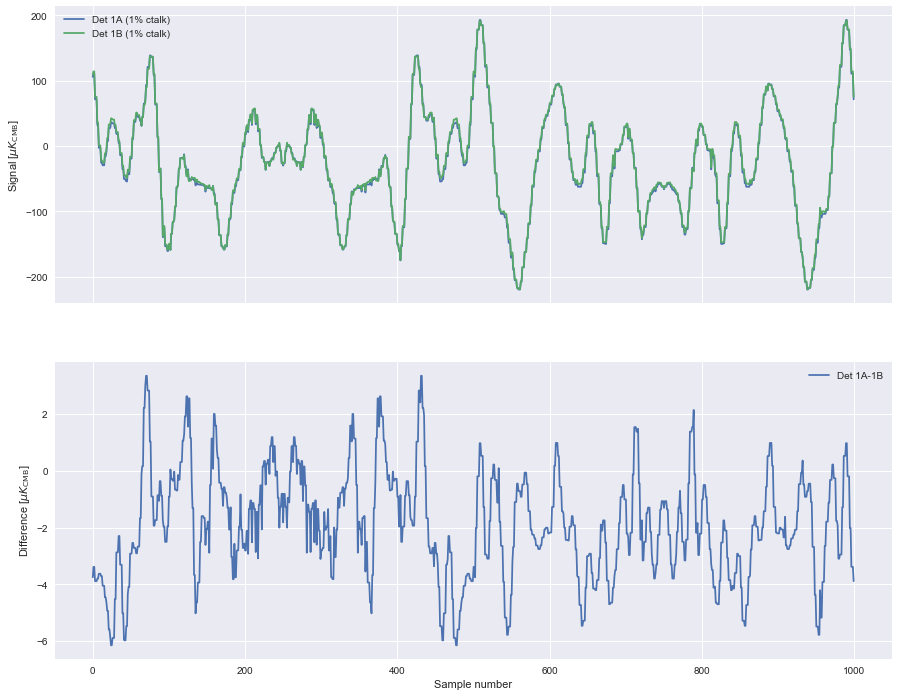

In [39]:
fig, (ax1, ax2) = plt.subplots(2, 1, sharex=True, figsize=(15, 12))

tod1 = ss.data(ss.chunks[0], beam=ss.beams[0][0])
tod2 = ss.data(ss.chunks[0], beam=ss.beams[0][1])
#tod3 = ss.data(ss.chunks[0], beam=ss.beams[1][0])
#tod4 = ss.data(ss.chunks[0], beam=ss.beams[1][1])

ax1.plot(tod1, label='Det 1A (1% ctalk)')
ax1.plot(tod2, label='Det 1B (1% ctalk)')
#ax1.plot(tod3, label='Det 2A (1% ctalk)')
#ax1.plot(tod4, label='Det 2B (1% ctalk)')

ax2.plot(tod1 - tod2, label='Det 1A-1B')
#ax2.plot(tod3 - tod4, label='Det 1A-1B')

ax1.legend()
ax2.legend()
ax1.set_ylabel(r'Signal [$\mu K_{\mathrm{CMB}}$]')
ax2.set_ylabel(r'Difference [$\mu K_{\mathrm{CMB}}$]')
ax2.set_xlabel('Sample number')